In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

import warnings
warnings.filterwarnings('ignore')


/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('course_730.csv', engine='python')

df_org = df

df = df.drop([list(df)[0], list(df)[-3], 'final_score', 'group'], axis=1)
#df = df.drop(['hw1_score', 'hw2_score', 'hw3_score', 'student_id'], axis=1)
df = df.drop(['student_id', 'hw2_score', 'hw3_score'], axis=1)

df = df.drop(['HW1_C', 'HW1_R', 'HW1_W', 'HW1_E'], axis=1)
df = df.drop(['HW2_C', 'HW2_R', 'HW2_W', 'HW2_E'], axis=1)
df = df.drop(['HW3_C', 'HW3_R', 'HW3_W', 'HW3_E'], axis=1)

df = df.rename(index=str, columns={list(df)[-1]: "label_2",
                              list(df)[-2]: "label_1"})
df = df[df.HW1.notna()]
df = df[df.HW2.notna()]
df = df[df.HW3.notna()]
df = df[df.HW3.notna()]
df = df[df.HW2 != 'error']
df = df[df.label_2 != '?�修']
df = df[df.label_1.notna()]


In [3]:
feature_list = list(df)
hw1_df = df[feature_list[3:14]]
hw1_df.head()

,hw1_score,w1_onlineDays,w1_onlineCount,w1_onlineTime,w1_passCount,w1_failCount,w1_SyntaxError,w1_NameError,w1_IndentationError,w1_ValueError,w1_TypeError
0,25.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,25.0,2.0,1.0,6002.317,62.0,38.0,11.0,8.0,7.0,0.0,12.0
8,25.0,1.0,1.0,3470.740,14.0,18.0,14.0,0.0,2.0,0.0,0.0
9,25.0,1.0,1.0,4327.470,58.0,27.0,8.0,14.0,3.0,0.0,2.0
12,25.0,1.0,1.0,3871.781,36.0,25.0,16.0,4.0,5.0,0.0,0.0


# Cross Correlation

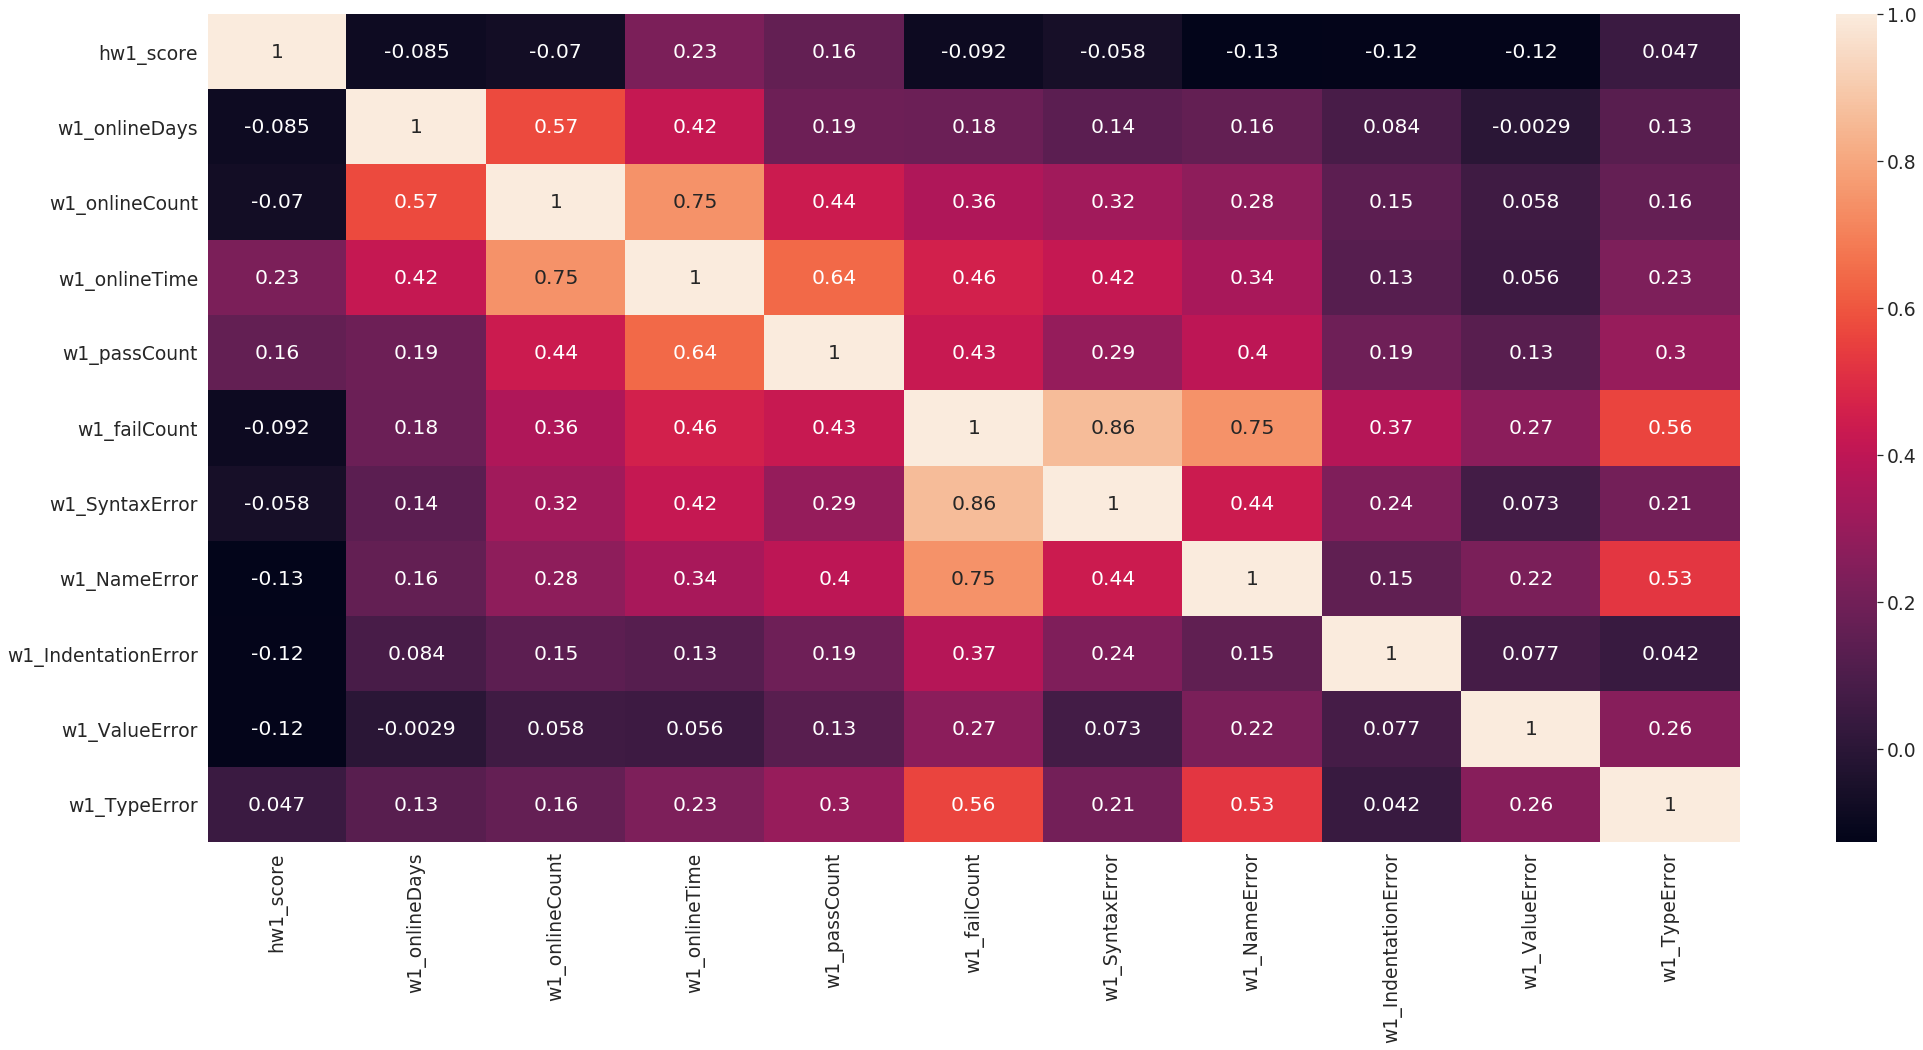

In [4]:
import seaborn as sns

Var_Corr = hw1_df.corr()
# plot the heatmap and annotation on it
sns.set(rc={'figure.figsize':(30, 15)})
sns.set(font_scale=1.7)
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

plt.tight_layout()
#plt.savefig('svm_conf.png', dpi=400)

# Distribution

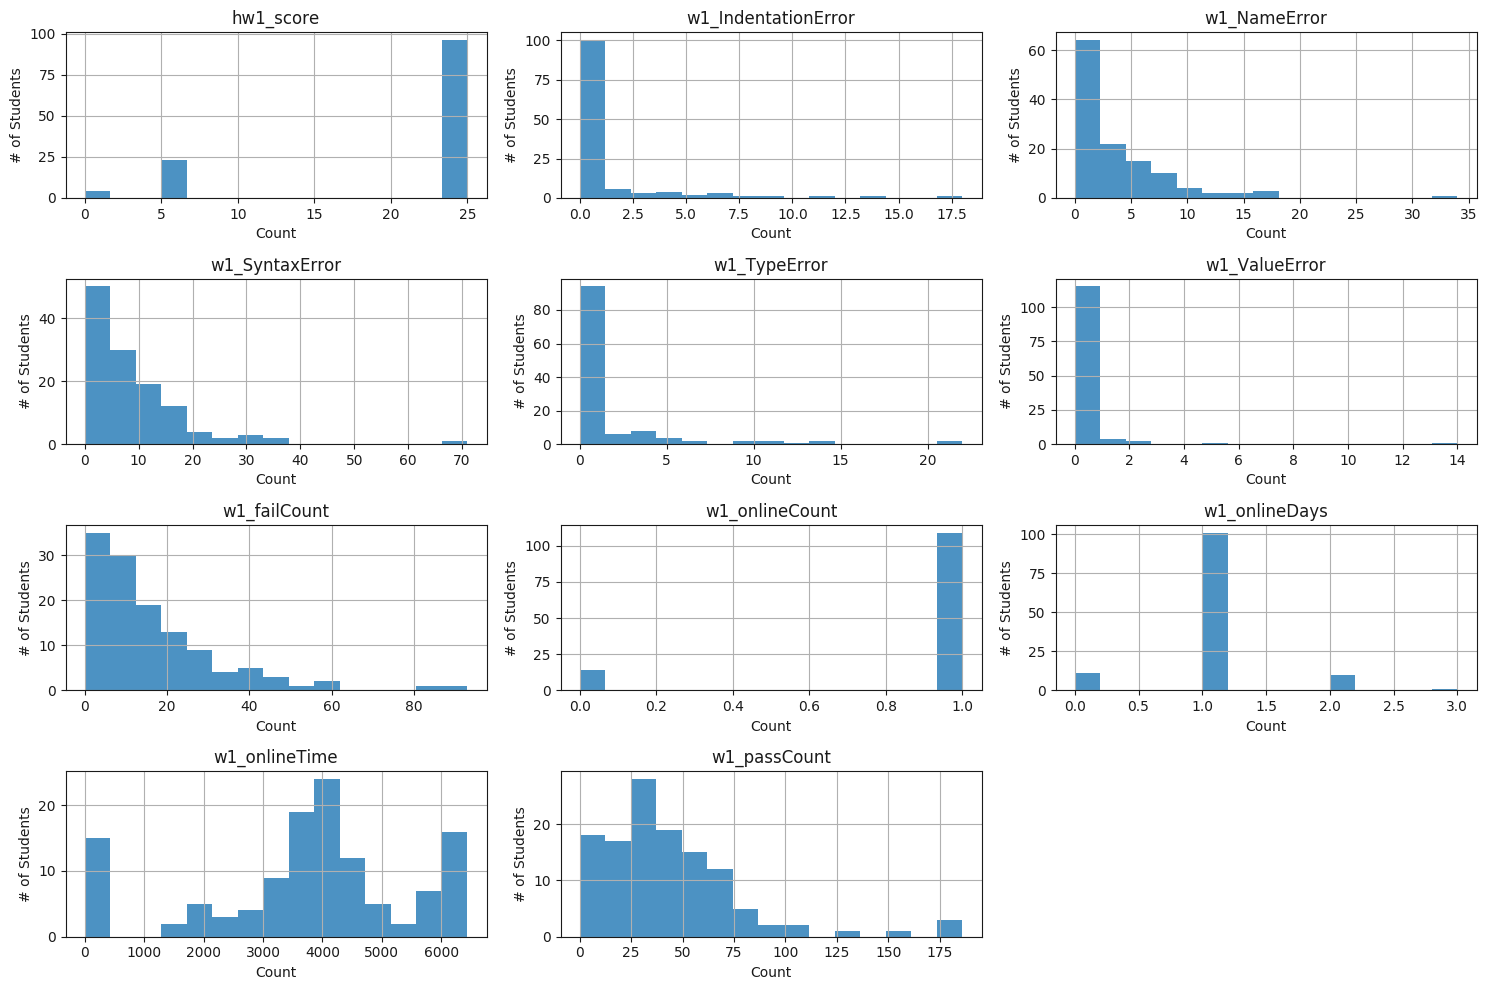

In [5]:
#plt.figure(figsize=(15, 15))
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#matplotlib.rc('xtick', labelsize=10) 
#matplotlib.rc('ytick', labelsize=10) 
#matplotlib.rc('axes', titlesize=10) 

ax = hw1_df.hist(alpha=0.8, bins=15, figsize=(15, 10))
#for x in ax:
#     x.set_title('x')

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students', fontsize=10)
        subplot.set_xlabel('Count', fontsize=10)

plt.tight_layout()
#plt.savefig('svm_conf.png', dpi=400)

# Create Class

In [6]:
hw1_df_km = hw1_df

hw1_df_km['class'] = hw1_df_km['hw1_score'] < 24
hw1_df_km['duration'] = hw1_df_km['w1_onlineTime'] / 60
hw1_df_km['duration'] = hw1_df_km['duration'].astype(int)

hw1_df_km = hw1_df_km.drop(['hw1_score', 'w1_onlineTime'], axis=1)
hw1_df_km

,w1_onlineDays,w1_onlineCount,w1_passCount,w1_failCount,w1_SyntaxError,w1_NameError,w1_IndentationError,w1_ValueError,w1_TypeError,class,duration
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0
5,2.0,1.0,62.0,38.0,11.0,8.0,7.0,0.0,12.0,False,100
8,1.0,1.0,14.0,18.0,14.0,0.0,2.0,0.0,0.0,False,57
9,1.0,1.0,58.0,27.0,8.0,14.0,3.0,0.0,2.0,False,72
12,1.0,1.0,36.0,25.0,16.0,4.0,5.0,0.0,0.0,False,64
14,1.0,1.0,28.0,15.0,3.0,7.0,5.0,0.0,0.0,False,55
15,1.0,1.0,18.0,3.0,1.0,1.0,0.0,0.0,0.0,False,97
16,1.0,1.0,29.0,9.0,5.0,0.0,4.0,0.0,0.0,False,49
17,1.0,1.0,27.0,16.0,11.0,1.0,0.0,0.0,4.0,False,63
18,1.0,1.0,31.0,12.0,11.0,1.0,0.0,0.0,0.0,False,101


# KaplanMeierFitter

In [7]:
kmf = KaplanMeierFitter() 
kmf.fit(durations = hw1_df_km.duration, event_observed = hw1_df_km['class'])
#kmf.event_table

<lifelines.KaplanMeierFitter: fitted with 123 observations, 96 censored>

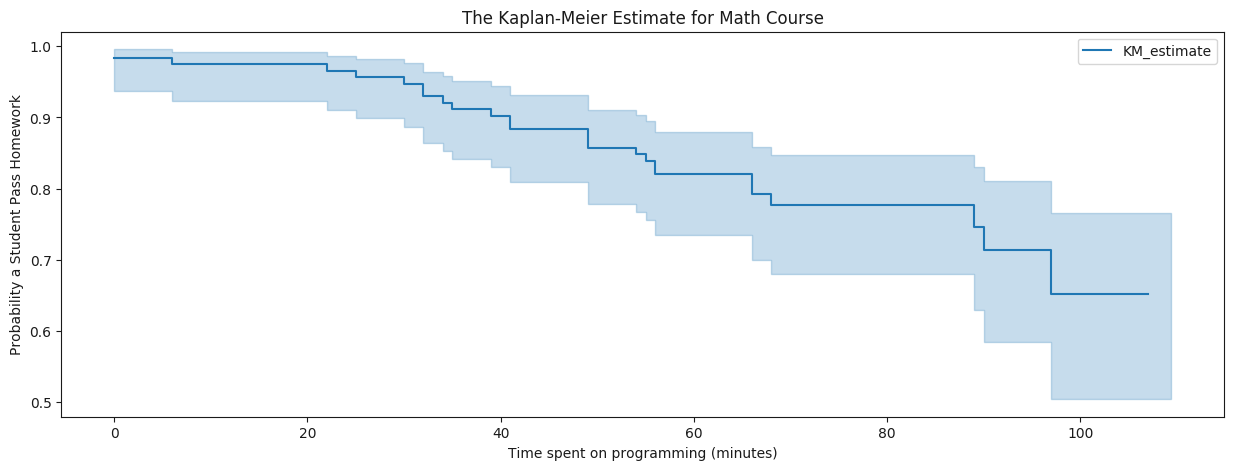

In [8]:

#plt.clf()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('figure', figsize=(15, 5)) 

# plot the KM estimate
kmf.plot()
# Add title and y-axis label
plt.title("The Kaplan-Meier Estimate for Math Course")
plt.ylabel("Probability a Student Pass Homework")
plt.xlabel("Time spent on programming (minutes)")

plt.show()

In [9]:

#variable = 'w1_ValueError'
#threadhold = 1

#variable = 'w1_TypeError'
#threadhold = 3


#variable = 'w1_SyntaxError'
#threadhold = 10

#best fit
#variable = 'w1_onlineDays'
#threadhold = 3

#best fit
variable = 'w1_passCount'
threadhold = 25

hw1_df_km['class_passCount'] = hw1_df_km[variable] < threadhold
#hw1_df_km['class_passCount'] = hw1_df_km.w1_TypeError < 3
hw1_df_km = hw1_df_km.drop([variable], axis=1)
hw1_df_km

,w1_onlineDays,w1_onlineCount,w1_failCount,w1_SyntaxError,w1_NameError,w1_IndentationError,w1_ValueError,w1_TypeError,class,duration,class_passCount
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0,True
5,2.0,1.0,38.0,11.0,8.0,7.0,0.0,12.0,False,100,False
8,1.0,1.0,18.0,14.0,0.0,2.0,0.0,0.0,False,57,True
9,1.0,1.0,27.0,8.0,14.0,3.0,0.0,2.0,False,72,False
12,1.0,1.0,25.0,16.0,4.0,5.0,0.0,0.0,False,64,False
14,1.0,1.0,15.0,3.0,7.0,5.0,0.0,0.0,False,55,False
15,1.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,False,97,True
16,1.0,1.0,9.0,5.0,0.0,4.0,0.0,0.0,False,49,False
17,1.0,1.0,16.0,11.0,1.0,0.0,0.0,4.0,False,63,False
18,1.0,1.0,12.0,11.0,1.0,0.0,0.0,0.0,False,101,False


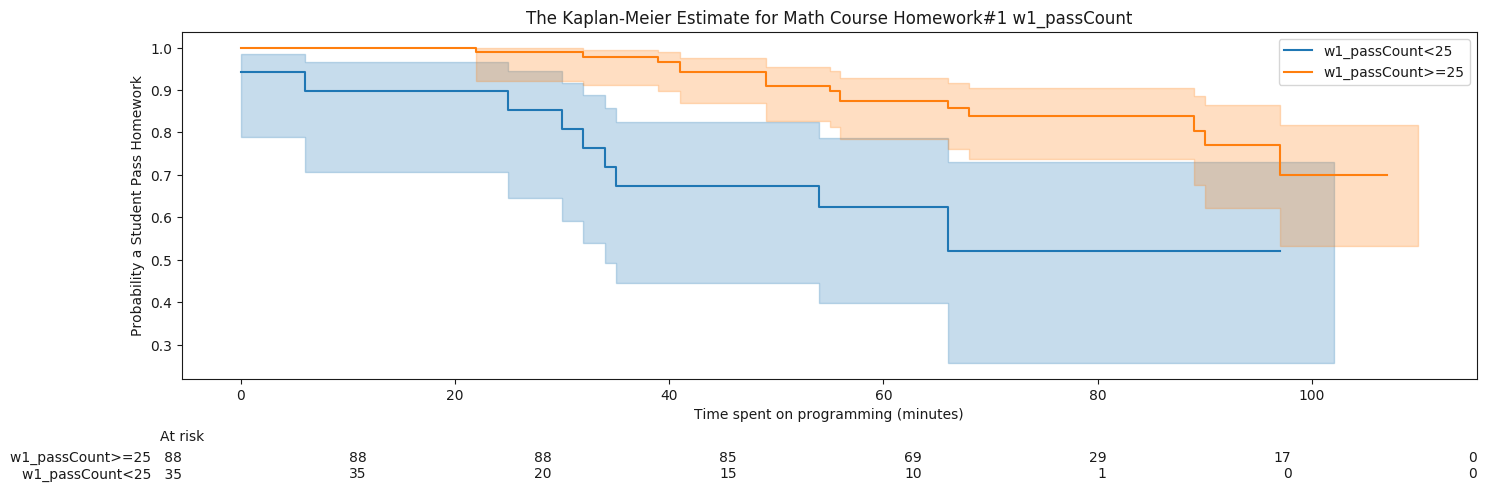

In [10]:
from lifelines import KaplanMeierFitter

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('figure', figsize=(15, 5)) 
ax = plt.subplot(111)

ix = hw1_df_km['class_passCount'] == True

kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(hw1_df_km.loc[ix]['duration'], 
                     hw1_df_km.loc[ix]['class'], 
                     label = variable + '<' + str(threadhold)).plot(ax=ax)

kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(hw1_df_km.loc[~ix]['duration'], 
                 hw1_df_km.loc[~ix]['class'],
                 label = variable + '>=' + str(threadhold)).plot(ax=ax)

plt.title("The Kaplan-Meier Estimate for Math Course Homework#1 " +  variable)
plt.ylabel("Probability a Student Pass Homework")
plt.xlabel("Time spent on programming (minutes)")

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)

plt.tight_layout()
plt.savefig('km_hw1_passcount.png', dpi=400)

# LogRank

In [11]:
from lifelines.statistics import multivariate_logrank_test


results = multivariate_logrank_test(hw1_df_km['duration'], 
                                    hw1_df_km['class_passCount'], 
                                    hw1_df_km['class'])
results.print_summary()

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
               t_0 = -1

---
test_statistic      p  -log2(p)
         11.46 <0.005     10.45


# Cox Proportional Hazard Model

In [12]:
from lifelines import CoxPHFitter

hw1_df_cph = hw1_df_km.drop(['w1_onlineCount'], axis=1)
#hw1_df_cph = hw1_df_km

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(hw1_df_cph, duration_col='duration', event_col='class')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 123 observations, 96 censored>
      duration col = 'duration'
         event col = 'class'
number of subjects = 123
  number of events = 27
    log-likelihood = -108.48
  time fit was run = 2019-02-10 11:55:55 UTC

---
                     coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
w1_onlineDays       -0.17       0.85      0.62 -0.27   0.79      0.34       -1.37        1.04
w1_failCount         0.04       1.04      0.12  0.32   0.75      0.42       -0.20        0.28
w1_SyntaxError      -0.07       0.93      0.13 -0.56   0.57      0.80       -0.32        0.18
w1_NameError         0.09       1.09      0.13  0.66   0.51      0.97       -0.17        0.35
w1_IndentationError  0.04       1.04      0.13  0.31   0.76      0.40       -0.22        0.30
w1_ValueError        0.12       1.13      0.15  0.81   0.42      1.25       -0.17        0.41
w1_TypeError        -0.19       0.83      0.15 -1.25   0.21      2.24       -0.49     

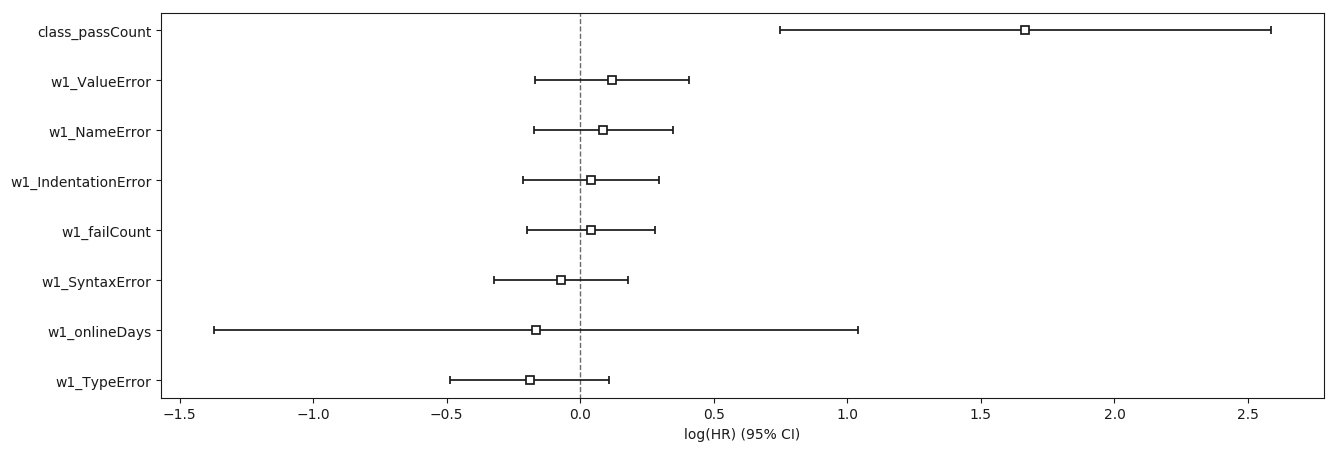

In [13]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('figure', figsize=(15, 5)) 
cph.plot()